In [1]:
import GPy
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import display
from tqdm import tqdm
import scipy
import time
import threading

import tensorflow as tf
import tf_agents
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()
np.random.seed(123)
random.seed(123)

import warnings
warnings.filterwarnings("ignore")

In [2]:
from platform import python_version
print("Python version: ", python_version())
print("NetworkX version: ", nx.__version__)
print("Scipy version: ", scipy.__version__)
print("Numpy version: ", np.__version__)
print("GPy version: ", GPy.__version__)
print("TensorFlow version: ", tf.__version__)
print("TF Agents version: ", tf_agents.__version__)

Python version:  3.9.7
NetworkX version:  2.6.3
Scipy version:  1.7.1
Numpy version:  1.20.3
GPy version:  1.10.0
TensorFlow version:  2.8.0
TF Agents version:  0.11.0


In [3]:
def flatten(liste):
    return [item for sublist in liste for item in sublist]

def preprocessing(X_s):
    X = []
    for liste in X_s:
        X += liste.copy()
    return np.array(X)

def copie_paths(paths):
    X = []
    for liste in paths:
        X.append(liste.copy())
    return X

def copy_X_D(X_D):
    X = []
    for liste in X_D:
        X.append(liste.copy())
    return np.array(X)

def concatenate(x, y):
    if len(x)==0:
        return y
    else:
        return np.concatenate((x, y))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def distance(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
        
def sigma_matrix(gp_model, X_v):
    return gp_model.kern.K(X_v, X_v)
    
def sigma_prime_matrix(gp_model, X_v, X_s):
    kernel = gp_model.rbf
    variance_n = float(gp_model.Gaussian_noise.variance)
    a = kernel.K(X_v, X_v)
    b = kernel.K(X_v, X_s)
    c = kernel.K(X_s, X_s)
    d = variance_n*np.eye(len(X_s))
    e = kernel.K(X_s, X_v)
    f = np.linalg.inv(c + d)
    g = np.dot(b, f)
    h = np.dot(g, e)
    return a - h

def reward_function(gp_model, X_v, X_s_old, X_s_new):
    if len(X_s_old)==0:
        sigma_prime_old = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_old = sigma_prime_matrix(gp_model, X_v, X_s_old)
    if len(X_s_new)==0:
        sigma_prime_new = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_new = sigma_prime_matrix(gp_model, X_v, X_s_new)
    return 0.5 * (np.log(np.linalg.det(sigma_prime_old)) - np.log(np.linalg.det(sigma_prime_new)))

def credit_assignment(env, reward, dones):
    if env.nb_agents==1:
        return np.array([reward])
    rewards = np.zeros(env.nb_agents)
    if reward==0:
        return rewards
    X_s = preprocessing(env.X_s)
    H = np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s)))
    for i in range(env.nb_agents):
        if not dones[i]:
            X_s_i = env.X_s.copy()
            del X_s_i[i]
            X_s_i = preprocessing(X_s_i)
            if len(X_s_i)==0:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_matrix(env.gp_model, env.X_v))) - H)
            else:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s_i))) - H)
    somme = np.sum(rewards)
    if somme==0:
        return rewards
    return rewards*(reward/(np.sum(rewards)))

def construct_graph(graph_dim, graph_unity):
    x = graph_dim[0]
    y = graph_dim[1]
    i, j = 0.0, 0.0
    graph = nx.Graph()
    for k in range(x*y):
        graph.add_node(k, coord=[i, j])
        i += graph_unity
        if i==x*graph_unity:
            i = 0.0
            j += graph_unity
    for k in range(x*y):
        if (k+1)%x!=0:
            graph.add_edge(k, k+1)
        if k<x*y-x:
            graph.add_edge(k, k+x)
    return graph
            
def show_graph(graph):
    nx.draw(graph, with_labels=True, font_weight='bold')

def remove_nodes_from_graph(graph, liste):
    graph.remove_nodes_from(liste)
    return graph

def incertitude_initiale(sigma, graph):
    return 0.5 * np.log(np.linalg.det(sigma)) + (graph.number_of_nodes()/2) * (1 + np.log(2*np.pi))

def coord_to_id(coord, graph_dim):
    return graph_dim[0] * int(coord[1]) + int(coord[0])

In [4]:
def collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, variance, lengthscale, memory_window, gamma):
    X_D = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    simulation_kernel = GPy.kern.RBF(input_dim = 2, variance=variance, lengthscale=lengthscale)
    cov = simulation_kernel.K(X_D)
    X, Y = [], []
    for _ in range(exploration_steps):
        Y_D = np.random.multivariate_normal(np.array(means), cov, 1)[0]
        Y_D = np.reshape(Y_D, (len(Y_D),1))
        Y_D[Y_D<0] = 0.1
        sparse_nodes = random.sample(range(0, graph.number_of_nodes()), nb_agents)
        sorted_nodes = sorted(sparse_nodes)
        if sorted_nodes[0]==0:
            for i in range(1,len(sorted_nodes)):
                if sorted_nodes[i]!=sorted_nodes[i-1]:
                    l = covariances[sorted_nodes[i]-1]
                    l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_D[0], Y_D[sorted_nodes[i]], memory_window, gamma)
        X.append(X_D[sparse_nodes])
        Y.append(Y_D[sparse_nodes])
    return incertitude_initiale(cov, graph), np.array(X), np.array(Y)

def hyperparameters_estimator(X, Y, gp_model, graph, graph_dim, memory_window, gamma):
    for i in range(len(X)):
        l = variances[coord_to_id(X[i], graph_dim)]
        l[0], l[1], l[2] = weighted_variance(l[0], l[1], l[2], Y[i][0], memory_window, gamma)
    cumul_var = 0
    coeffs = 0
    for ele in variances:
        coeffs += ele[2]
        cumul_var += float(ele[0])*ele[2]
    variance = cumul_var/coeffs
    ###########################################
    X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    moyenne = np.reshape(gp_model.predict(X_v)[0], (graph.number_of_nodes(),))
    ###########################################
    lengthscale, cpt = 0, 0
    for i in range(len(covariances)):
        if covariances[i][0]>1:
            covariance = covariances[i][1] - covariances[i][2]*covariances[i][3]
            if 0<covariance<variance:
                cpt += covariances[i][0]
                lengthscale += find_lengthscale(X_v[0], X_v[i+1], covariance, variance) * covariances[i][0]
    if cpt!=0:
        lengthscale /= cpt
    else:
        lengthscale = 0
    return moyenne, variance, lengthscale

def find_lengthscale(x1, x2, y, var):
    return distance(x1, x2) * np.sqrt(-0.5/np.log(y/var))

def weighted_covariance(n, moy_prod, moy_x, moy_y, x_new, y_new, memory_capacity, gamma):
    if n>memory_capacity:
        return n + 1, gamma * moy_prod + (1-gamma) * x_new * y_new, gamma * moy_x + (1-gamma) * x_new, gamma * moy_y + (1-gamma) * y_new
    return n + 1, (n * moy_prod + x_new * y_new)/(n + 1), (n * moy_x + x_new)/(n + 1), (n * moy_y + y_new)/(n + 1)

def weighted_variance(var, moy, n, x_new, memory_capacity, gamma):
    if n>memory_capacity:
        a = gamma*(var+(moy**2)) + (1-gamma)*(x_new**2)
        moy = gamma * moy + (1-gamma) * x_new
    else:
        a = (n*(var+(moy**2)) + (x_new**2))/(n+1)
        moy = (n*moy+x_new)/(n+1)
    return a-moy**2, moy, n+1

def in_collision(env, agent):
    for i in range(env.nb_agents):
        if i!=agent and env.paths[i][-1]==env.paths[agent][-1]:
            return True
    return False
    
def nb_agents_in_collision(env):
    cpt = 0
    for agent in range(env.nb_agents):
        if in_collision(env, agent):
            cpt += 1
    return cpt

In [5]:
graph_dim = (5, 5)
graph_unity = 1
graph = construct_graph(graph_dim, graph_unity)
X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
means = [60, 30, 20, 15, 10, 30, 27.5, 25, 17.5, 11.25, 20, 25, 22.5, 20, 12.5, 15, 17.5, 20, 17.5, 15, 10, 11.25, 12.5, 15, 12.5]
nb_agents = 4
exploration_steps = 25
variance_lengthscale = [10, 2]
memory_window = 1000
gamma = 0.997

variances = [[0, 0, 0] for _ in range(graph.number_of_nodes())]
covariances = [[0, 0, 0, 0] for _ in range(graph.number_of_nodes()-1)]

incertitude, x, y = collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, variance_lengthscale[0], variance_lengthscale[1], memory_window, gamma)

x = np.reshape(x, (nb_agents*exploration_steps,2))
y = np.reshape(y, (nb_agents*exploration_steps,1))

gp_model = GPy.models.GPRegression(x, y, GPy.kern.RBF(2))
gp_model.optimize(messages=False)

moyenne, var, l = hyperparameters_estimator(x, y, gp_model, graph, graph_dim, memory_window, gamma)
print("Variance: ", var)
print("Lengthscale: ", l)
print("Carte: ", moyenne)
print("Incertitude initiale : ", incertitude_initiale(sigma_matrix(gp_model, X_v), graph))

Variance:  6.308772713397341
Lengthscale:  [1.66076309]
Carte:  [59.85483899 32.11779084 18.48143476 13.82936597  9.90567897 31.42864025
 23.56361743 21.16534224 17.11838639  9.15379147 18.64726466 22.34266819
 24.11017583 19.78071109 10.78276591 12.74158079 17.33884851 18.80636175
 16.94169911 12.14119882  7.33509245  9.70290213 11.42148126 13.4479377
 13.23346071]
Incertitude initiale :  72.33041096055982


In [6]:
def update_gp_model(gp_model, x, y, graph, graph_dim, memory_window, gamma, display_gp_model=False):
    moy, variance, lengthscale = hyperparameters_estimator(x, y, gp_model, graph, graph_dim, memory_window, gamma)
    X = np.concatenate((gp_model.X, x))[-1000:]
    Y = np.concatenate((gp_model.Y, y))[-1000:]
    gp_model.set_XY(X, Y)
    gp_model.optimize(messages=False)
    if display_gp_model:
        display(gp_model)
    return gp_model, moy, variance, lengthscale

def take_measurements(nodes, means, X_v, memory_window, gamma):
    simulation_kernel = GPy.kern.RBF(input_dim = 2, variance=variance_lengthscale[0], lengthscale=variance_lengthscale[1])
    cov = simulation_kernel.K(X_v)
    Y_v = np.random.multivariate_normal(np.array(means), cov, 1)[0]
    Y_v = np.reshape(Y_v, (len(Y_v),1))
    Y_v[Y_v<0] = 0.1
    sorted_nodes = sorted(nodes)
    if sorted_nodes[0]==0:
        for i in range(1,len(sorted_nodes)):
            if sorted_nodes[i]!=sorted_nodes[i-1]:
                l = covariances[sorted_nodes[i]-1]
                l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_v[0], Y_v[sorted_nodes[i]], memory_window, gamma)
    return X_v[nodes], Y_v[nodes]

In [7]:
class pfeEnv(py_environment.PyEnvironment):

    def __init__(self, graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, variance_0, lengthscale_0, memory_window, gamma, train_env=True):
        self.nb_agents = nb_agents
        self.graph = graph
        self.graph_unity = graph_unity
        self.graph_dim = graph_dim
        self.initial_budgets = budgets/self.graph_unity
        self.budgets = self.initial_budgets.copy()
        if initial_positions!=None:
            self.initial_positions = copie_paths(initial_positions)
            self.paths = copie_paths(initial_positions)
        else:
            self.initial_positions = None
            self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        self.X_v = np.array([self.graph.nodes[i]["coord"] for i in range(self.graph.number_of_nodes())])
        self.gp_model = gp_model
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=3, name="action")
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.nb_agents*2,), dtype=np.float32, minimum=np.zeros((self.nb_agents*2,)), name="observation")
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self._episode_ended = False
        #################################
        self.cpt_update_gp_model = 0
        self.memory_window, self.gamma = memory_window, gamma
        self.x, self.y = np.array([]), np.array([])
        self.liste_variances, self.liste_lengthscales = [variance_0], [lengthscale_0]
        self.train_env = train_env
        self.agents_in_collision = []
        
    def current_node(self, id_agent):
        return self.paths[id_agent][-1]

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def formater(self):
        for i in range(len(self.neighbors)):
            liste = self.neighbors[i]
            node = self.current_node(i)
            try:
                if liste[0]>=node-1:
                    liste.insert(0,-1)
                if liste[1]!=node-1:
                    liste.insert(1,-1)
                if liste[2]!=node+1:
                    liste.insert(2,-1)
            except:
                pass
            for _ in range(4-len(liste)):
                liste.append(-1)

    def _reset(self):
        if self.initial_positions!=None:
            self.paths = copie_paths(self.initial_positions)
        else:
            self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)] 
        self.formater()
        self.budgets = self.initial_budgets.copy()
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float32))
        
    def _step(self, abstract_actions):
        if self._episode_ended:
            return self.reset()
        actions = []
        for i in range(self.nb_agents):
            actions.append(self.neighbors[i][abstract_actions[i]])
        X_s_old = preprocessing(self.X_s)
        for i in range(self.nb_agents):
            if not self.dones[i]:
                if actions[i]!=-1:
                    self.X_s[i].append([graph.nodes[actions[i]]["coord"][0], graph.nodes[actions[i]]["coord"][1]])
                    self.budgets[i] -= 1
                else:
                    actions[i] = self.current_node(i)
                    self.budgets[i] -= 0.3
                if self.budgets[i]<1:
                    self.dones[i] = True
                    self.cpt_done += 1
                self.paths[i].append(actions[i])
                coord = self.graph.nodes[self.current_node(i)]["coord"]
                self._state[2*i] = coord[0]
                self._state[2*i+1] = coord[1]
        
        if self.train_env:
            positions, mesures = take_measurements(actions, means, self.X_v, self.memory_window, self.gamma)
            self.x = concatenate(self.x, positions)
            self.y = concatenate(self.y, mesures)
            self.cpt_update_gp_model = (self.cpt_update_gp_model + 1)%100
            if self.cpt_update_gp_model==0:
                self.gp_model, m, var, l = update_gp_model(self.gp_model, self.x, self.y, self.graph, self.graph_dim, self.memory_window, self.gamma)
                self.liste_variances.append(var)
                self.liste_lengthscales.append(l)
                self.moy = m
                self.x, self.y = np.array([]), np.array([])
        
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        reward = reward_function(self.gp_model, self.X_v, X_s_old, preprocessing(self.X_s))
        nb = nb_agents_in_collision(self)
        self.agents_in_collision.append(nb)
        #reward -= (reward * nb * 0.25)
        if self.cpt_done==self.nb_agents:
            self._episode_ended = True
            return ts.termination(np.array(self._state, dtype=np.float32), reward)
        return ts.transition(np.array(self._state, dtype=np.float32), reward=reward, discount=0.97)

In [8]:
num_iterations = 60000
fc_layer_params = (128,64,)
replay_buffer_capacity = 30000
batch_size = 128
learning_rate = 1e-5

num_atoms = 51
min_q_value = -20
max_q_value = 20
n_step_update = 3

num_eval_episodes = 10
log_eval_interval = 1000

max_episode_length = 25
budgets = 25 * np.ones(nb_agents)

In [9]:
initial_positions = None #[[random.randint(0, graph.number_of_nodes()-1)] for i in range(nb_agents)]
train_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, memory_window, gamma, train_env=True), duration=max_episode_length)
eval_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, memory_window, gamma, train_env=False), duration=max_episode_length)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

agents_tf = []
eval_policies = []
collect_policies = []
policies_checkpointers = []

for i in range(nb_agents):
    categorical_q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        fc_layer_params=fc_layer_params)
        
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)

    agents_tf.append(categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=categorical_q_net,
        optimizer=optimizer,
        min_q_value=min_q_value,
        max_q_value=max_q_value,
        n_step_update=n_step_update,
        target_update_period=5,
        target_update_tau=0.05,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=0.99,
        train_step_counter=train_step_counter))

    agents_tf[-1].initialize()

    eval_policies.append(agents_tf[-1].policy)
    collect_policies.append(agents_tf[-1].collect_policy)
    
    policies_checkpointers.append(common.Checkpointer(ckpt_dir='Collisions_Politique_'+str(i), policy=eval_policies[-1]))

In [10]:
def compute_avg_return(environment, policies, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            actions = []
            for i in range(nb_agents):
                actions.append(policies[i].action(time_step).action.numpy()[0])
            actions = tf.convert_to_tensor([actions])
            time_step = environment.step(actions)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, environment_py, policies):
    time_step = environment.current_time_step()
    actions = []
    actions_step = []
    dones = environment_py.dones.copy()
    for i in range(nb_agents):
        actions_step.append(policies[i].action(time_step))
        actions.append(actions_step[-1].action.numpy()[0])
    actions = tf.convert_to_tensor([actions])
    next_time_step = environment.step(actions)
    rewards = credit_assignment(environment_py, next_time_step.reward.numpy()[0], dones)
    for i in range(nb_agents):
        if not dones[i]:
            nts = next_time_step._replace(reward=tf.convert_to_tensor([rewards[i]], dtype=np.float32))
            traj = trajectory.from_transition(time_step, actions_step[i], nts)
            replay_buffers[i].add_batch(traj)

In [12]:
replay_buffers = []
for i in range(nb_agents):
    replay_buffers.append(tf_agents.replay_buffers.TFUniformReplayBuffer(
        data_spec = agents_tf[i].collect_data_spec,
        batch_size = train_env.batch_size,
        max_length = replay_buffer_capacity))

iterators = []
for i in range(nb_agents):
    dataset = replay_buffers[i].as_dataset(
        num_parallel_calls=3,
        sample_batch_size=batch_size,
        num_steps=2).prefetch(3)

    iterators.append(iter(dataset))

In [13]:
print(compute_avg_return(eval_env, eval_policies, num_eval_episodes))

steps = []
avg = []
err = []

for i in range(nb_agents):
    agents_tf[i].train = common.function(agents_tf[i].train)
    agents_tf[i].train_step_counter.assign(0)

for _ in tqdm(range(500)):
    collect_step(train_env, train_py_env, collect_policies)
    
for step in tqdm(range(1, num_iterations+1)):
    for _ in range(1):
        collect_step(train_env, train_py_env, collect_policies)
    
    for i in range(nb_agents):
        experience, _ = next(iterators[i])
        agents_tf[i].train(experience=experience)

    if step%log_eval_interval==0:
        avg_return = compute_avg_return(eval_env, eval_policies, num_eval_episodes)
        steps.append(step)
        avg.append(avg_return)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        print("Variance : ", train_py_env.liste_variances[-1])
        print("Lengthscale : ", train_py_env.liste_lengthscales[-1])
        err.append(np.mean((train_py_env.moy-means)**2))
        print("MSE de la moyenne : ", err[-1])

16.539692


  0%|                                                                                        | 0/60000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
  2%|█▎                                                                         | 1003/60000 [01:05<5:31:45,  2.96it/s]

step = 1000: Average Return = 24.86440658569336
Variance :  9.8357937075869
Lengthscale :  [1.95504867]
MSE de la moyenne :  1.0260209733981598


  3%|██▍                                                                       | 2003/60000 [02:25<14:39:01,  1.10it/s]

step = 2000: Average Return = 26.90337562561035
Variance :  9.934669687885005
Lengthscale :  [1.98326516]
MSE de la moyenne :  0.41413848019025457


  5%|███▊                                                                       | 3003/60000 [03:40<9:07:57,  1.73it/s]

step = 3000: Average Return = 38.71929168701172
Variance :  10.035791933358063
Lengthscale :  [1.9986679]
MSE de la moyenne :  0.41788720900325765


  7%|█████                                                                      | 4003/60000 [04:55<8:14:10,  1.89it/s]

step = 4000: Average Return = 42.70213317871094
Variance :  9.962110485223723
Lengthscale :  [1.97238778]
MSE de la moyenne :  0.4663025017173844


  8%|██████▎                                                                    | 5002/60000 [06:07<8:30:25,  1.80it/s]

step = 5000: Average Return = 33.3515625
Variance :  9.942394468905707
Lengthscale :  [1.96460125]
MSE de la moyenne :  0.31418021053897566


 10%|███████▌                                                                   | 6003/60000 [07:23<8:30:39,  1.76it/s]

step = 6000: Average Return = 39.026947021484375
Variance :  9.84023132858811
Lengthscale :  [1.96068071]
MSE de la moyenne :  0.4457796883514067


 12%|████████▊                                                                  | 7003/60000 [08:40<8:42:07,  1.69it/s]

step = 7000: Average Return = 39.14008331298828
Variance :  9.809043949100936
Lengthscale :  [1.99760381]
MSE de la moyenne :  0.35476618907749546


 13%|██████████                                                                 | 8003/60000 [09:54<6:46:47,  2.13it/s]

step = 8000: Average Return = 34.68074035644531
Variance :  9.953876181423816
Lengthscale :  [1.9636328]
MSE de la moyenne :  0.214170403727475


 15%|███████████▎                                                               | 9003/60000 [11:11<8:03:43,  1.76it/s]

step = 9000: Average Return = 39.214439392089844
Variance :  10.072926759022886
Lengthscale :  [1.97616578]
MSE de la moyenne :  0.2503572056608944


 17%|████████████▎                                                             | 10002/60000 [12:24<7:27:12,  1.86it/s]

step = 10000: Average Return = 40.80994415283203
Variance :  9.961158268231765
Lengthscale :  [2.0198376]
MSE de la moyenne :  0.3665709889162161


 18%|█████████████▌                                                            | 11004/60000 [13:38<5:31:08,  2.47it/s]

step = 11000: Average Return = 39.79048538208008
Variance :  10.0928975360422
Lengthscale :  [1.98727507]
MSE de la moyenne :  0.3883652137714248


 20%|██████████████▊                                                           | 12003/60000 [14:52<7:46:57,  1.71it/s]

step = 12000: Average Return = 37.00612258911133
Variance :  10.044872646728345
Lengthscale :  [1.97525767]
MSE de la moyenne :  0.5129842915816724


 22%|████████████████                                                          | 13002/60000 [16:11<7:05:42,  1.84it/s]

step = 13000: Average Return = 41.26437759399414
Variance :  9.895725787736271
Lengthscale :  [1.9697364]
MSE de la moyenne :  0.5211810803108017


 23%|█████████████████▎                                                        | 14003/60000 [17:25<7:03:56,  1.81it/s]

step = 14000: Average Return = 35.30743408203125
Variance :  9.93250335239761
Lengthscale :  [1.99097549]
MSE de la moyenne :  0.3303240955643546


 25%|██████████████████▌                                                       | 15003/60000 [18:40<7:24:57,  1.69it/s]

step = 15000: Average Return = 40.269798278808594
Variance :  9.975225200152785
Lengthscale :  [1.98414682]
MSE de la moyenne :  0.2581240965626421


 27%|███████████████████▋                                                      | 16003/60000 [19:55<6:54:00,  1.77it/s]

step = 16000: Average Return = 40.057044982910156
Variance :  10.028204294411493
Lengthscale :  [1.97643661]
MSE de la moyenne :  0.3453569806227648


 28%|████████████████████▉                                                     | 17003/60000 [21:12<5:36:57,  2.13it/s]

step = 17000: Average Return = 40.54528045654297
Variance :  9.885090432461647
Lengthscale :  [1.97716508]
MSE de la moyenne :  0.35038234480655883


 30%|██████████████████████▏                                                   | 18004/60000 [22:27<4:51:38,  2.40it/s]

step = 18000: Average Return = 38.531070709228516
Variance :  9.917256579910465
Lengthscale :  [1.98557837]
MSE de la moyenne :  0.3003471639374834


 32%|███████████████████████▍                                                  | 19003/60000 [23:41<5:43:58,  1.99it/s]

step = 19000: Average Return = 41.56684112548828
Variance :  10.124683382989124
Lengthscale :  [1.94772783]
MSE de la moyenne :  0.40416780490004384


 33%|████████████████████████▋                                                 | 20003/60000 [24:58<6:26:53,  1.72it/s]

step = 20000: Average Return = 41.90004348754883
Variance :  10.152731688423396
Lengthscale :  [1.95588186]
MSE de la moyenne :  0.4540331764841786


 35%|█████████████████████████▉                                                | 21001/60000 [26:10<8:36:02,  1.26it/s]

step = 21000: Average Return = 42.819297790527344
Variance :  10.134007537311193
Lengthscale :  [1.98548598]
MSE de la moyenne :  0.3357448064295874


 37%|███████████████████████████▏                                              | 22003/60000 [27:28<6:01:50,  1.75it/s]

step = 22000: Average Return = 38.40540313720703
Variance :  10.233881286823397
Lengthscale :  [1.97174189]
MSE de la moyenne :  0.32711209468510516


 38%|████████████████████████████▎                                             | 23002/60000 [28:41<6:04:53,  1.69it/s]

step = 23000: Average Return = 42.44709396362305
Variance :  10.123672632279185
Lengthscale :  [1.98900919]
MSE de la moyenne :  0.48712956856753065


 40%|█████████████████████████████▌                                            | 24003/60000 [29:58<6:02:48,  1.65it/s]

step = 24000: Average Return = 42.19451141357422
Variance :  9.830253327969183
Lengthscale :  [2.00818597]
MSE de la moyenne :  0.26466808577065637


 42%|██████████████████████████████▊                                           | 25002/60000 [31:16<5:28:48,  1.77it/s]

step = 25000: Average Return = 43.55809783935547
Variance :  9.688865359687039
Lengthscale :  [2.00720122]
MSE de la moyenne :  0.4710473800360189


 43%|████████████████████████████████                                          | 26004/60000 [32:37<3:30:02,  2.70it/s]

step = 26000: Average Return = 39.89484405517578
Variance :  9.80256733934881
Lengthscale :  [2.00751494]
MSE de la moyenne :  0.19902691401189046


 45%|█████████████████████████████████▎                                        | 27003/60000 [33:52<5:07:48,  1.79it/s]

step = 27000: Average Return = 39.67634963989258
Variance :  9.783161176677291
Lengthscale :  [2.00743555]
MSE de la moyenne :  0.24421595162933898


 47%|██████████████████████████████████▌                                       | 28002/60000 [35:09<6:14:00,  1.43it/s]

step = 28000: Average Return = 44.97947311401367
Variance :  9.927602198969383
Lengthscale :  [1.9841665]
MSE de la moyenne :  0.33987477720397175


 48%|███████████████████████████████████▊                                      | 29002/60000 [36:22<4:42:47,  1.83it/s]

step = 29000: Average Return = 42.75503158569336
Variance :  9.938262697188424
Lengthscale :  [1.97577352]
MSE de la moyenne :  0.3912771283173497


 50%|█████████████████████████████████████                                     | 30003/60000 [37:36<4:31:09,  1.84it/s]

step = 30000: Average Return = 39.5245475769043
Variance :  10.01502303601163
Lengthscale :  [1.98034241]
MSE de la moyenne :  0.21209562608587715


 52%|██████████████████████████████████████▏                                   | 31003/60000 [38:50<4:37:32,  1.74it/s]

step = 31000: Average Return = 42.1297492980957
Variance :  9.709631677942944
Lengthscale :  [2.0078704]
MSE de la moyenne :  0.23117200923913792


 53%|███████████████████████████████████████▍                                  | 32002/60000 [40:04<4:26:27,  1.75it/s]

step = 32000: Average Return = 43.19251251220703
Variance :  9.676282828420174
Lengthscale :  [2.02049047]
MSE de la moyenne :  0.2092564372489304


 55%|████████████████████████████████████████▋                                 | 33003/60000 [41:19<4:16:51,  1.75it/s]

step = 33000: Average Return = 39.476768493652344
Variance :  9.700248192458204
Lengthscale :  [1.98276663]
MSE de la moyenne :  0.37936253149744154


 57%|█████████████████████████████████████████▉                                | 34003/60000 [42:32<3:45:14,  1.92it/s]

step = 34000: Average Return = 39.223876953125
Variance :  9.81592737434238
Lengthscale :  [1.97146347]
MSE de la moyenne :  0.3272211437963965


 58%|███████████████████████████████████████████▏                              | 35004/60000 [43:49<3:28:15,  2.00it/s]

step = 35000: Average Return = 40.25791549682617
Variance :  9.895877846826469
Lengthscale :  [1.95918606]
MSE de la moyenne :  0.282638310985523


 60%|████████████████████████████████████████████▍                             | 36001/60000 [45:02<5:18:08,  1.26it/s]

step = 36000: Average Return = 40.34299850463867
Variance :  9.844395722132244
Lengthscale :  [1.99552676]
MSE de la moyenne :  0.25813438998644


 62%|█████████████████████████████████████████████▋                            | 37003/60000 [46:17<3:04:52,  2.07it/s]

step = 37000: Average Return = 37.390159606933594
Variance :  9.974390251040765
Lengthscale :  [1.99198616]
MSE de la moyenne :  0.3303258064882598


 63%|██████████████████████████████████████████████▊                           | 38002/60000 [47:33<3:44:56,  1.63it/s]

step = 38000: Average Return = 40.578033447265625
Variance :  9.975981202410487
Lengthscale :  [1.97455417]
MSE de la moyenne :  0.42705876381803265


 65%|████████████████████████████████████████████████                          | 39003/60000 [48:48<2:59:58,  1.94it/s]

step = 39000: Average Return = 36.36102294921875
Variance :  9.952459483793954
Lengthscale :  [1.97430763]
MSE de la moyenne :  0.369547463338637


 67%|█████████████████████████████████████████████████▎                        | 40002/60000 [50:04<3:06:40,  1.79it/s]

step = 40000: Average Return = 45.709373474121094
Variance :  9.841753552416927
Lengthscale :  [1.99077063]
MSE de la moyenne :  0.35219539979683995


 68%|██████████████████████████████████████████████████▌                       | 41004/60000 [51:22<2:33:28,  2.06it/s]

step = 41000: Average Return = 36.77003479003906
Variance :  9.858988965540812
Lengthscale :  [1.98599404]
MSE de la moyenne :  0.46362847228434617


 70%|███████████████████████████████████████████████████▊                      | 42003/60000 [52:35<2:49:30,  1.77it/s]

step = 42000: Average Return = 39.15499496459961
Variance :  9.72322820794614
Lengthscale :  [1.97255769]
MSE de la moyenne :  0.3224509230840621


 72%|█████████████████████████████████████████████████████                     | 43002/60000 [53:52<2:32:22,  1.86it/s]

step = 43000: Average Return = 38.36793899536133
Variance :  9.747820414728158
Lengthscale :  [1.96954062]
MSE de la moyenne :  0.22160443635940466


 73%|██████████████████████████████████████████████████████▎                   | 44003/60000 [55:06<2:33:38,  1.74it/s]

step = 44000: Average Return = 42.951663970947266
Variance :  9.916731570463543
Lengthscale :  [1.96903578]
MSE de la moyenne :  0.3698465912554559


 75%|███████████████████████████████████████████████████████▌                  | 45004/60000 [56:21<2:06:54,  1.97it/s]

step = 45000: Average Return = 41.15504455566406
Variance :  10.040360332400986
Lengthscale :  [1.96233425]
MSE de la moyenne :  0.3191701473118642


 77%|████████████████████████████████████████████████████████▋                 | 46002/60000 [57:36<2:18:13,  1.69it/s]

step = 46000: Average Return = 36.889835357666016
Variance :  9.869962489094847
Lengthscale :  [1.99324993]
MSE de la moyenne :  0.1820361251796479


 78%|█████████████████████████████████████████████████████████▉                | 47004/60000 [58:50<1:51:47,  1.94it/s]

step = 47000: Average Return = 40.838897705078125
Variance :  9.773140980806682
Lengthscale :  [2.00240905]
MSE de la moyenne :  0.3252851519888069


 80%|█████████████████████████████████████████████████████████▌              | 48003/60000 [1:00:05<1:56:57,  1.71it/s]

step = 48000: Average Return = 44.30256652832031
Variance :  9.78542223378439
Lengthscale :  [1.99640233]
MSE de la moyenne :  0.21727790339006245


 82%|██████████████████████████████████████████████████████████▊             | 49002/60000 [1:01:17<1:46:37,  1.72it/s]

step = 49000: Average Return = 39.457054138183594
Variance :  9.98543360436323
Lengthscale :  [1.96665344]
MSE de la moyenne :  0.2860278281057821


 83%|████████████████████████████████████████████████████████████            | 50003/60000 [1:02:32<1:34:22,  1.77it/s]

step = 50000: Average Return = 40.653892517089844
Variance :  9.886905779470208
Lengthscale :  [1.96989797]
MSE de la moyenne :  0.2892982459306868


 85%|█████████████████████████████████████████████████████████████▏          | 51002/60000 [1:03:47<1:27:15,  1.72it/s]

step = 51000: Average Return = 38.44258117675781
Variance :  9.918416645693723
Lengthscale :  [1.98561422]
MSE de la moyenne :  0.20563388581677572


 87%|██████████████████████████████████████████████████████████████▍         | 52002/60000 [1:05:00<1:14:48,  1.78it/s]

step = 52000: Average Return = 38.18368911743164
Variance :  9.936685095676708
Lengthscale :  [1.96776185]
MSE de la moyenne :  0.14897774904010702


 88%|███████████████████████████████████████████████████████████████▌        | 53002/60000 [1:06:14<1:03:17,  1.84it/s]

step = 53000: Average Return = 40.53230285644531
Variance :  9.859083875383897
Lengthscale :  [1.99066604]
MSE de la moyenne :  0.2666259867979771


 90%|████████████████████████████████████████████████████████████████▊       | 54003/60000 [1:07:30<1:05:22,  1.53it/s]

step = 54000: Average Return = 42.15492630004883
Variance :  10.094756523265493
Lengthscale :  [1.95968772]
MSE de la moyenne :  0.2709124837073134


 92%|███████████████████████████████████████████████████████████████████▊      | 55003/60000 [1:08:43<41:32,  2.00it/s]

step = 55000: Average Return = 43.62751007080078
Variance :  9.9149011194759
Lengthscale :  [1.97171141]
MSE de la moyenne :  0.25660515035864423


 93%|█████████████████████████████████████████████████████████████████████     | 56002/60000 [1:09:57<39:50,  1.67it/s]

step = 56000: Average Return = 37.47145080566406
Variance :  9.992333761192697
Lengthscale :  [1.95430268]
MSE de la moyenne :  0.36658211117658224


 95%|██████████████████████████████████████████████████████████████████████▎   | 57003/60000 [1:11:10<25:29,  1.96it/s]

step = 57000: Average Return = 40.317588806152344
Variance :  10.04694730616389
Lengthscale :  [1.95372055]
MSE de la moyenne :  0.44572671328261093


 97%|███████████████████████████████████████████████████████████████████████▌  | 58003/60000 [1:12:27<18:50,  1.77it/s]

step = 58000: Average Return = 37.698219299316406
Variance :  10.124205179461299
Lengthscale :  [1.95451942]
MSE de la moyenne :  0.2865877711307913


 98%|████████████████████████████████████████████████████████████████████████▊ | 59002/60000 [1:13:43<10:06,  1.65it/s]

step = 59000: Average Return = 37.24289321899414
Variance :  10.012851334853318
Lengthscale :  [1.97157059]
MSE de la moyenne :  0.32515963531649705


100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [1:15:01<00:00, 13.33it/s]

step = 60000: Average Return = 40.79149627685547
Variance :  9.920798526137286
Lengthscale :  [1.99052209]
MSE de la moyenne :  0.3875696584711295


## Avec pénalisation des collisions

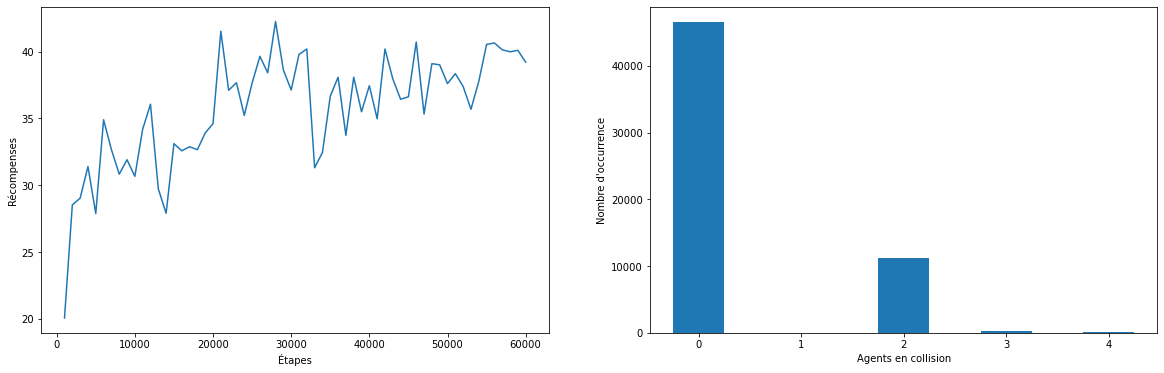

In [14]:
bins = []
for x in range(nb_agents+1):
    bins.append(x-0.5)
    bins.append(x+0.5)
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(steps, avg)
plt.xlabel("Étapes")
plt.ylabel("Récompenses")
plt.subplot(1, 2, 2)
plt.hist(train_py_env.agents_in_collision, bins=bins, rwidth=0.5)
plt.xlabel("Agents en collision")
plt.ylabel("Nombre d'occurrence")
plt.show()

In [15]:
print(train_py_env.agents_in_collision)

[0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [23]:
liste = [0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 3, 2, 3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 0, 3, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 4, 0, 2, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 3, 0, 3, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 4, 0, 4, 0, 4, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 3, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 3, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 3, 3, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 0, 2, 2, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 4, 2, 0, 2, 4, 2, 0, 0, 2, 2, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 3, 2, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 3, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 4, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 3, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 4, 4, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 4, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 4, 4, 2, 0, 0, 0, 2, 4, 4, 3, 4, 0, 2, 2, 3, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 0, 0, 2, 3, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 2, 2, 2, 2, 3, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 3, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 4, 2, 4, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 4, 0, 4, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 3, 2, 0, 2, 0, 2, 0, 0, 0, 3, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 3, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 3, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 3, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 3, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 3, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 0, 2, 0, 0, 4, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 3, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 4, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 3, 0, 0, 0, 2, 2, 2, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 3, 2, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 3, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 3, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 3, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 3, 2, 0, 0, 0, 0, 0, 2, 3, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 4, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 4, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 3, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 4, 4, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 3, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 2, 2, 2, 2, 3, 2, 0, 2, 0, 3, 2, 3, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 3, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 4, 2, 2, 0, 0, 0, 2, 4, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 3, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 4, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 3, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 3, 0, 2, 2, 2, 0, 0, 0, 0, 4, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 2, 3, 2, 3, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 3, 0, 0, 2, 2, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 3, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 3, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 2, 0, 2, 2, 4, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 2, 4, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 3, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 4, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 4, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 3, 3, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 4, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 3, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 4, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 3, 2, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 4, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 4, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 3, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 3, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 3, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 3, 2, 2, 0, 2, 0, 3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 2, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 3, 0, 2, 2, 0, 0, 0, 0, 3, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 2, 2, 3, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 3, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 3, 3, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 4, 4, 4, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 4, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 4, 2, 4, 4, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 3, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 3, 3, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 3, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 3, 4, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 4, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 4, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 4, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 4, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 4, 4, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 3, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 4, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 4, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 4, 4, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 4, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 4, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 3, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 4, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 0, 0, 2, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0]

cpt  = 0
for ele in liste:
    if ele==0:
        cpt += 1
print(cpt)

cpt  = 0
for ele in liste:
    if ele==2:
        cpt += 1
print(cpt)

cpt  = 0
for ele in liste:
    if ele==3:
        cpt += 1
print(cpt)

cpt  = 0
for ele in liste:
    if ele==4:
        cpt += 1
print(cpt)

46560
11151
273
190


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


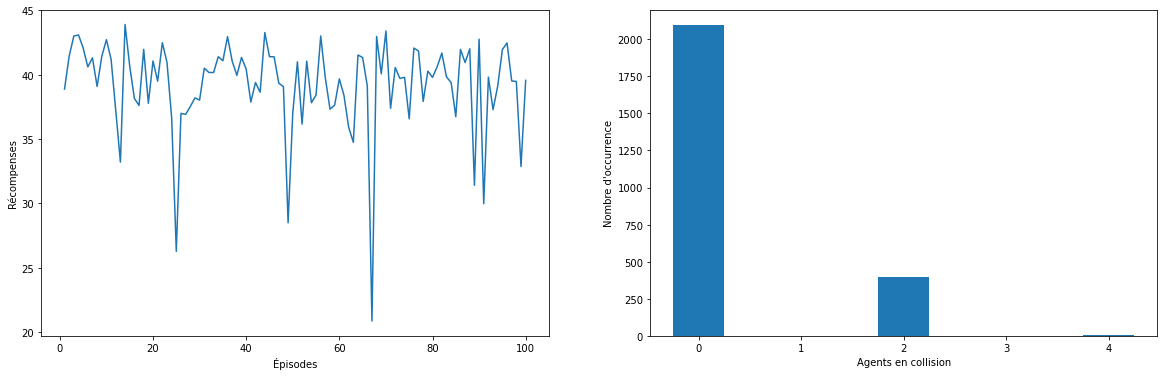

In [16]:
rewards = []
episodes = 100
a = len(eval_py_env.agents_in_collision)
for _ in tqdm(range(episodes)):
    time_step = eval_env.reset()
    episode_return = 0.0
    while not time_step.is_last():
        actions = []
        for i in range(nb_agents):
            actions.append(eval_policies[i].action(time_step).action.numpy()[0])
        actions = tf.convert_to_tensor([actions])
        time_step = eval_env.step(actions)
        episode_return += time_step.reward
    rewards.append(episode_return.numpy()[0])
    
bins = []
for x in range(nb_agents+1):
    bins.append(x-0.5)
    bins.append(x+0.5)
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(range(1, episodes+1), rewards)
plt.xlabel("Épisodes")
plt.ylabel("Récompenses")
plt.subplot(1, 2, 2)
plt.hist(eval_py_env.agents_in_collision[a:], bins=bins, rwidth=0.5)
plt.xlabel("Agents en collision")
plt.ylabel("Nombre d'occurrence")
plt.show()

In [17]:
cpt  = 0
for ele in eval_py_env.agents_in_collision[a:]:
    if ele!=0:
        cpt += 1
print(cpt)

405


## Sans pénalisation des collisions

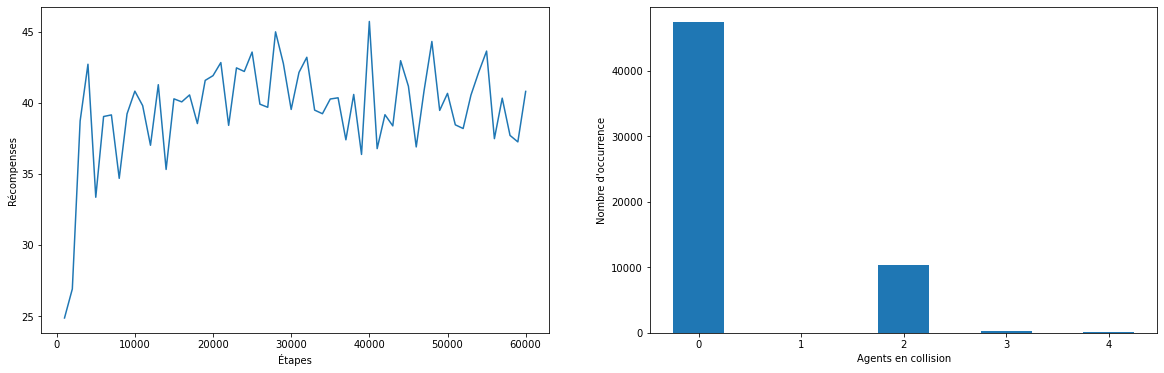

In [14]:
bins = []
for x in range(nb_agents+1):
    bins.append(x-0.5)
    bins.append(x+0.5)
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(steps, avg)
plt.xlabel("Étapes")
plt.ylabel("Récompenses")
plt.subplot(1, 2, 2)
plt.hist(train_py_env.agents_in_collision, bins=bins, rwidth=0.5)
plt.xlabel("Agents en collision")
plt.ylabel("Nombre d'occurrence")
plt.show()

In [15]:
print(train_py_env.agents_in_collision)

[2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 

In [21]:
liste = [2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 3, 0, 3, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 4, 0, 2, 2, 2, 4, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 0, 2, 2, 0, 4, 2, 4, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 4, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 4, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 0, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 4, 4, 4, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 3, 4, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 4, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 3, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 3, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 4, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 2, 0, 0, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 3, 2, 2, 3, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 3, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 3, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 3, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 3, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 3, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 4, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 3, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 4, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 4, 0, 2, 0, 0, 0, 2, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 3, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 3, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 3, 3, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 2, 2, 0, 0, 2, 2, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 3, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 4, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 3, 2, 2, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 4, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 3, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 4, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 4, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 4, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 3, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 4, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 2, 0, 3, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 4, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 4, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 3, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 3, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 3, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 4, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 3, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 3, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 4, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 2, 2, 2, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 2, 2, 0, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 4, 2, 3, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 4, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 4, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 3, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 3, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 3, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 2, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 4, 4, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 3, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 4, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 4, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 3, 2, 2, 0, 2, 3, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 3, 3, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 3, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 3, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 4, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 3, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 3, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 3, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 2, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 4, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 4, 0, 0, 4, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 4, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 4, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 4, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 4, 4, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 4, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 4, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 4, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 3, 0, 4, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 4, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0]

cpt  = 0
for ele in liste:
    if ele==0:
        cpt += 1
print(cpt)

cpt  = 0
for ele in liste:
    if ele==2:
        cpt += 1
print(cpt)

cpt  = 0
for ele in liste:
    if ele==3:
        cpt += 1
print(cpt)

cpt  = 0
for ele in liste:
    if ele==4:
        cpt += 1
print(cpt)

47434
10375
217
148


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s]


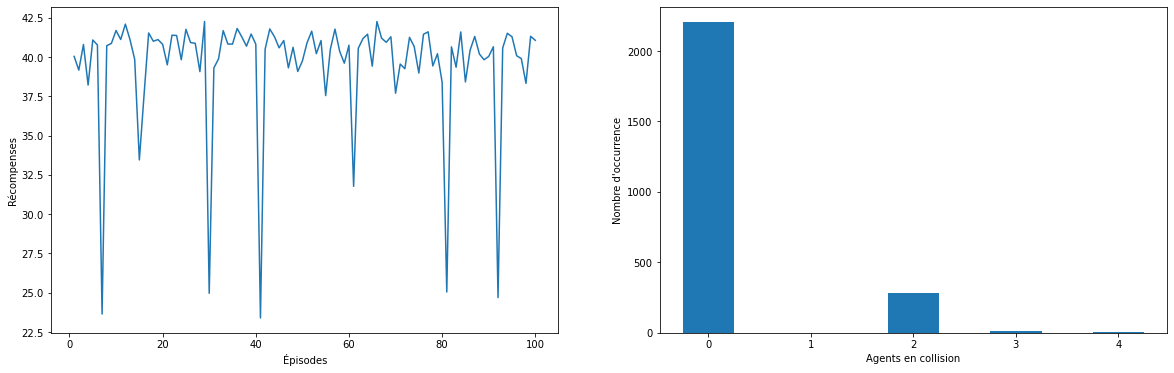

In [24]:
rewards = []
episodes = 100
a = len(eval_py_env.agents_in_collision)
for _ in tqdm(range(episodes)):
    time_step = eval_env.reset()
    episode_return = 0.0
    while not time_step.is_last():
        actions = []
        for i in range(nb_agents):
            actions.append(eval_policies[i].action(time_step).action.numpy()[0])
        actions = tf.convert_to_tensor([actions])
        time_step = eval_env.step(actions)
        episode_return += time_step.reward
    rewards.append(episode_return.numpy()[0])
    
bins = []
for x in range(nb_agents+1):
    bins.append(x-0.5)
    bins.append(x+0.5)
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(range(1, episodes+1), rewards)
plt.xlabel("Épisodes")
plt.ylabel("Récompenses")
plt.subplot(1, 2, 2)
plt.hist(eval_py_env.agents_in_collision[a:], bins=bins, rwidth=0.5)
plt.xlabel("Agents en collision")
plt.ylabel("Nombre d'occurrence")
plt.show()

In [25]:
cpt  = 0
for ele in eval_py_env.agents_in_collision[a:]:
    if ele!=0:
        cpt += 1
print(cpt)

295


In [ ]:
for i in range(nb_agents):
    policies_checkpointers[i].save(global_step=agents_tf[i].train_step_counter)